In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# df = pd.read_csv('/home/ila/Desktop/Train/input.csv')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [34]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# import sys
# !{sys.executable} -m pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy as spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd', 'organization', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [36]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]]


In [37]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [38]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.538*"ax" + 0.083*"_" + 0.043*"max" + 0.023*"internet" + 0.011*"family" + '
  '0.007*"iran" + 0.007*"fbi" + 0.006*"ai" + 0.006*"intel" + 0.006*"mr"'),
 (1,
  '0.067*"proof" + 0.059*"gateway" + 0.055*"michigan" + 0.015*"cooperation" + '
  '0.009*"n" + 0.008*"cord" + 0.006*"wipe" + 0.005*"in" + 0.005*"declaration" '
  '+ 0.005*"bk"'),
 (2,
  '0.027*"do" + 0.016*"say" + 0.016*"make" + 0.015*"think" + 0.014*"go" + '
  '0.014*"know" + 0.013*"time" + 0.012*"well" + 0.012*"see" + 0.012*"people"'),
 (3,
  '0.029*"state" + 0.025*"law" + 0.020*"people" + 0.020*"issue" + '
  '0.019*"government" + 0.018*"right" + 0.016*"public" + 0.015*"child" + '
  '0.013*"accept" + 0.012*"person"'),
 (4,
  '0.139*"physical" + 0.056*"direct" + 0.056*"robert" + 0.032*"rob" + '
  '0.026*"adam" + 0.025*"daughter" + 0.020*"human_being" + 0.013*"ho" + '
  '0.010*"cmu" + 0.009*"sister"'),
 (5,
  '0.061*"season" + 0.047*"nhl" + 0.047*"goal" + 0.044*"scott" + 0.043*"wing" '
  '+ 0.034*"pen" + 0.030*"van" + 0.029

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.273586618120898

Coherence Score:  0.5137725268806684


In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.358190  0.017466       1        1  35.056388
8      0.282086 -0.220941       2        1  16.038074
14     0.294960 -0.081830       3        1  14.324566
0      0.003513 -0.050854       4        1   6.009609
3      0.186896  0.225523       5        1   5.584477
7      0.094502 -0.166008       6        1   4.229489
15     0.187580  0.245032       7        1   4.160934
6      0.080528  0.111891       8        1   3.849803
10     0.011232 -0.100317       9        1   2.105076
17    -0.069537 -0.050285      10        1   1.578076
12    -0.049271  0.110787      11        1   1.456548
19    -0.105393 -0.013312      12        1   1.386440
9     -0.056588 -0.045939      13        1   1.252655
11    -0.107564  0.020524      14        1   1.137261
5     -0.160923  0.000434      15        1   0.615804
18    -0.159995 -0.002577      16        1   0.440359
16    -0.190495 -0.001130      17        1   0.273142
4     -0.191265 -0.000081      18        1   0.244990
13    -0.204290  0.000814      19        1   0.150895
1     -0.204166  0.000805      20        1   0.105415, topic_info=              Term          Freq         Total Category  logprob  loglift
5422            ax  49570.000000  49570.000000  Default  30.0000  30.0000
18            line  18756.000000  18756.000000  Default  29.0000  29.0000
26    organization  17206.000000  17206.000000  Default  28.0000  28.0000
1086             _   7674.000000   7674.000000  Default  27.0000  27.0000
232          write  14416.000000  14416.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6677    consulting      0.017292      1.241361  Topic20 -11.4454   2.5813
6788     connected      0.017292      1.241362  Topic20 -11.4454   2.5813
4658       connect      0.017293      1.241407  Topic20 -11.4454   2.5813
6517    connection      0.017292      1.241394  Topic20 -11.4454   2.5813
6195         laugh      0.017292      1.241388  Topic20 -11.4454   2.5813

[875 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1086      4  0.999908             _
1589      5  0.998664        accept
95        3  0.999091        access
3756     16  0.980767  access_digex
1779      5  0.734032           act
...     ...       ...           ...
45        9  0.247415          year
45       11  0.001371          year
45       13  0.023703          year
4430     18  0.942316          york
2608     19  0.989301          zone

[1078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 15, 1, 4, 8, 16, 7, 11, 18, 13, 20, 10, 12, 6, 19, 17, 5, 14, 2])

In [41]:
import os
os.environ.update({'MALLET_HOME':r'/home/ila/Documents/repos/python-works/artificialintelligence/topic_modelling/mallet-2.0.8/bin/mallet'})
mallet_path = '/home/ila/Documents/repos/python-works/artificialintelligence/topic_modelling/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('god', 0.0234208658623137),
   ('christian', 0.01899477385637783),
   ('people', 0.009923220852958256),
   ('bible', 0.009755468094715789),
   ('church', 0.008194077037228208),
   ('word', 0.008000516162333054),
   ('book', 0.0074714497709529645),
   ('man', 0.007432737595973933),
   ('love', 0.00671011032969869),
   ('religion', 0.006477837279824505)]),
 (3,
  [('car', 0.029099116172492806),
   ('bike', 0.012077253070999086),
   ('buy', 0.010957393656427132),
   ('article', 0.009975363092879417),
   ('organization', 0.008855503678307461),
   ('line', 0.008149130816808228),
   ('ride', 0.008062987784918077),
   ('drive', 0.007580586806333236),
   ('write', 0.006650242061919612),
   ('engine', 0.0065124132108953705)]),
 (12,
  [('armenian', 0.01411155525840363),
   ('israel', 0.013087329473519496),
   ('people', 0.010441412862568816),
   ('israeli', 0.009559440658918589),
   ('war', 0.008933524901489395),
   ('arab', 0.007297608717299458),
   ('jew', 0.007027326912955034),
   (

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [43]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


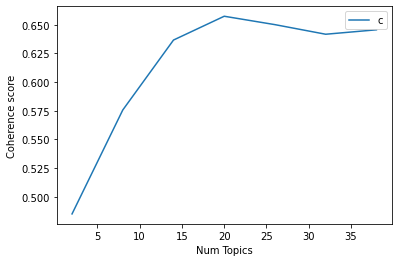

In [44]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has Coherence Value of", round(cv, 4))


Num Topics =  2  has Coherence Value of 0.485
Num Topics =  8  has Coherence Value of 0.5756
Num Topics =  14  has Coherence Value of 0.6367
Num Topics =  20  has Coherence Value of 0.6574
Num Topics =  26  has Coherence Value of 0.6501
Num Topics =  32  has Coherence Value of 0.6417
Num Topics =  38  has Coherence Value of 0.6456


In [46]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.033*"time" + 0.032*"good" + 0.028*"make" + 0.027*"thing" + 0.019*"ve" + '
  '0.017*"bad" + 0.013*"lot" + 0.013*"start" + 0.013*"put" + 0.013*"back"'),
 (1,
  '0.029*"car" + 0.014*"article" + 0.012*"bike" + 0.011*"organization" + '
  '0.010*"line" + 0.010*"write" + 0.008*"ride" + 0.008*"drive" + 0.007*"buy" + '
  '0.006*"road"'),
 (2,
  '0.016*"line" + 0.011*"work" + 0.011*"power" + 0.009*"organization" + '
  '0.008*"current" + 0.008*"ground" + 0.007*"wire" + 0.007*"high" + '
  '0.006*"low" + 0.006*"question"'),
 (3,
  '0.026*"game" + 0.019*"team" + 0.015*"year" + 0.015*"play" + 0.013*"player" '
  '+ 0.012*"win" + 0.008*"season" + 0.007*"hockey" + 0.007*"fan" + '
  '0.005*"good"'),
 (4,
  '0.031*"key" + 0.014*"system" + 0.011*"encryption" + 0.009*"bit" + '
  '0.009*"security" + 0.009*"message" + 0.008*"technology" + 0.008*"chip" + '
  '0.008*"government" + 0.008*"public"'),
 (5,
  '0.012*"question" + 0.012*"exist" + 0.010*"write" + 0.010*"people" + '
  '0.010*"claim" + 0.009*"

In [47]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1709,"car, article, bike, organization, line, write,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,17.0,0.1781,"drive, card, system, problem, window, scsi, dr...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,0.0,0.1860,"time, good, make, thing, ve, bad, lot, start, ...",From: (Thomas E Willis) Subject: PB questions....
3,3,8.0,0.1599,"line, organization, university, sale, price, n...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,18.0,0.1214,"space, system, launch, earth, nasa, year, rese...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,11.0,0.4507,"gun, law, state, people, fire, crime, kill, we...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,12.0,0.1092,"drug, study, article, organization, food, line...",From: (brian manning delaney) Subject: Brain T...
7,7,17.0,0.5713,"drive, card, system, problem, window, scsi, dr...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,14.0,0.1136,"file, window, program, image, version, display...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,17.0,0.2459,"drive, card, system, problem, window, scsi, dr...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [48]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3729,"time, good, make, thing, ve, bad, lot, start, ...","From: (Tom) Subject: Fred and Tom, ad naseum X..."
1,1.0,0.6134,"car, article, bike, organization, line, write,...",From: (DEMOSTHENIS A. ZEPPOS) Subject: Re: Int...
2,2.0,0.7746,"line, work, power, organization, current, grou...","From: Subject: Grounding power wiring, was Re:..."
3,3.0,0.9417,"game, team, year, play, player, win, season, h...",From: (Rocket) Subject: NHL Final point standi...
4,4.0,0.9049,"key, system, encryption, bit, security, messag...",From: (Clipper Chip Announcement) Subject: tex...


In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"car, article, bike, organization, line, write,...",188.0,0.0166
1.0,17.0,"drive, card, system, problem, window, scsi, dr...",1042.0,0.0921
2.0,0.0,"time, good, make, thing, ve, bad, lot, start, ...",507.0,0.0448
3.0,8.0,"line, organization, university, sale, price, n...",1067.0,0.0943
4.0,18.0,"space, system, launch, earth, nasa, year, rese...",530.0,0.0468
...,...,...,...,...
11309.0,12.0,"drug, study, article, organization, food, line...",NaN,NaN
11310.0,17.0,"drive, card, system, problem, window, scsi, dr...",NaN,NaN
11311.0,17.0,"drive, card, system, problem, window, scsi, dr...",NaN,NaN
11312.0,8.0,"line, organization, university, sale, price, n...",NaN,NaN
